In [1]:
import xgboost as xg
# import dask.dataframe as dd
import polars as pl
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score

In [2]:

#For making pretty LaTeX plots
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 18,
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.figsize": (8, 6),
    "figure.dpi": 100,
    "savefig.dpi": 200,
    "savefig.format": "png",
    "savefig.transparent": True,
    "axes.grid": True,
    "grid.linewidth": 0.5,
    "grid.linestyle": "--",
    "grid.color": "0.8",
    "image.cmap": "Blues",
    "lines.linewidth": 1.5,
    "lines.markersize": 6,
    "text.usetex": True, "mathtext.fontset": "cm",
    "pgf.preamble": r"\usepackage[utf8]{inputenc}\usepackage[T1]{fontenc}\usepackage{cmbright}"
})

In [3]:
data = pl.read_csv('../data/preprocessed/engineered_training_set.csv')
display(data)

srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_brand_bool,position,srch_destination_id,srch_booking_window,srch_saturday_night_bool,orig_destination_distance,random_bool,click_bool,gross_bookings_usd,booking_bool,has_hist_starrating,has_hist_adr_usd,score1d2,normalized_prop_starrating,normalized_score1d2,normalized_prop_review_score,hotel_quality,normalized_hotel_quality,price_per_person,avg_price_per_day,ump,price_diff,starrating_diff,total_price,score2ma,promotion_count,promotion_any
i64,str,i64,i64,str,str,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,str,i64,i64
1,null,12,187,null,null,219,893,1,27,23246,0,1,null,1,0,null,0,1,1,0.0,-0.093205,0.0,0.016094,-0.023134,0.5691247,26.1925,104.77,36.404964,null,null,104.77,null,1,1
1,null,12,187,null,null,219,10404,1,26,23246,0,1,null,1,0,null,0,1,1,0.0,1.2116711,0.0,0.466718,0.5035167,0.6655399,42.685,170.74,-17.806987,null,null,170.74,null,1,1
1,null,12,187,null,null,219,21315,1,21,23246,0,1,null,1,0,null,0,1,1,0.0,-0.093205,0.0,0.9173418,0.247241,0.6186229,44.95,179.8,-42.797387,null,null,179.8,null,1,1
1,null,12,187,null,null,219,27348,1,34,23246,0,1,null,1,0,null,0,1,1,0.0,-1.398082,0.0,0.466718,-0.279409,0.5222077,150.6925,602.77,-522.129581,null,null,602.77,null,1,1
1,null,12,187,null,null,219,29604,1,4,23246,0,1,null,1,0,null,0,1,1,0.0,1.2116711,0.0,0.016094,0.368329,0.6407908,35.895,143.58,-5.200488,null,null,143.58,null,1,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
332785,null,5,219,null,null,219,77700,1,2,16974,21,0,550.92,0,0,null,0,1,1,0.0,0.0,0.0,0.475383,0.142615,0.5994687,39.333333,118.0,-117.0,null,null,118.0,null,0,0
332785,null,5,219,null,null,219,88083,1,3,16974,21,0,553.14,0,0,null,0,1,1,0.0,0.0,0.0,0.475383,0.142615,0.5994687,29.666667,89.0,-88.0,null,null,89.0,null,0,0
332785,null,5,219,null,null,219,94508,1,4,16974,21,0,544.43,0,0,null,0,1,1,0.0,0.0,0.0,0.118846,0.035654,0.5798871,33.0,99.0,-98.0,null,null,99.0,null,0,0


Text(0.5, 1.0, 'Histogram of prop_country_id')

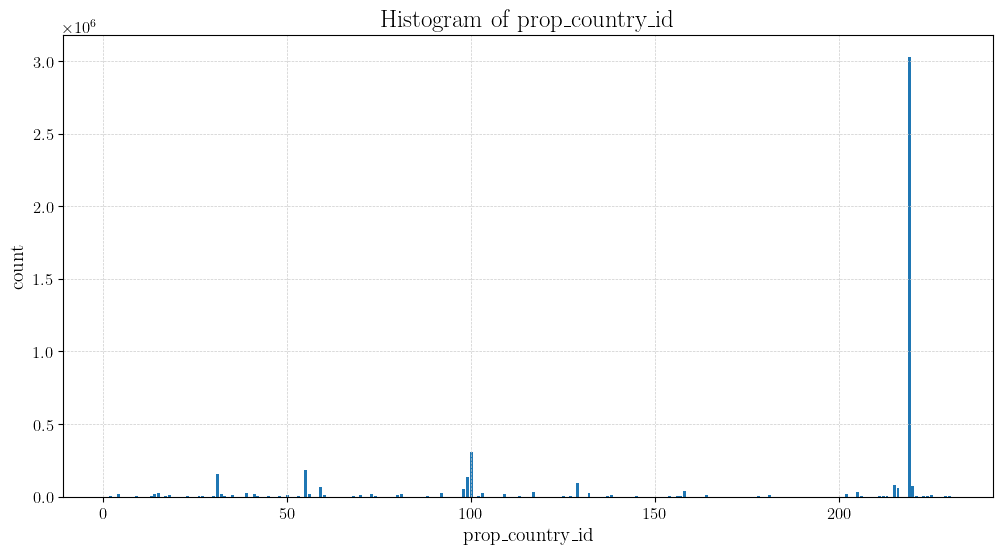

In [4]:
# hist of prop_country_id
count = data['prop_country_id'].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(count['prop_country_id'], count['count'])
plt.xlabel('prop_country_id')
plt.ylabel('count')
plt.title('Histogram of prop_country_id')

The following code is very messy, but essentially, all you need to do is choose a number of partitions, after which the variable `partition_list` will be a list of np.arrays, each of which are the `prop_country_id`'s for one partitions. Then you can train a model on each partition

In [87]:
partitions = 12
partitions_list = [np.array([219])]
countries = count['prop_country_id'].to_numpy()
indx = countries != 219
countries = countries[indx]
count_array = count['count'].to_numpy()


# We take a cumsum, and get the indices at which we should split the data, sometimes we get empty partitions
count_array = count_array[indx]
cum_sum = np.cumsum(count_array)
total = cum_sum[-1]
partition_size = total // partitions
for i in range(0, partitions):
    idx_min = np.argmax(cum_sum >= partition_size * i)
    idx_max = np.argmax(cum_sum > partition_size * (i + 1))
    if i == partitions - 1:
        partitions_list.append(countries[idx_min:])
    else:
        partitions_list.append(countries[idx_min:idx_max])

# For printing and getting all the empty partitions
counts = 0
zeros = []
for i, part in enumerate(partitions_list):
    countries = count.filter(count['prop_country_id'].is_in(part))
    part_count = countries['count']
    counts += sum(part_count)
    if i < 9:
        print(f'Count for partion  {i+1}: {sum(part_count)}')
    else:
        print(f'Count for partion {i+1}: {sum(part_count)}')

    if sum(part_count) == 0:
        zeros.append(0)
    else:
        zeros.append(1)

# Remove empty partitions
partitions_list = [x for i, x in enumerate(partitions_list) if zeros[i] == 1]

assert counts == sum(count['count']), f'Expected {sum(count["count"])} but got {counts}'

Count for partion  1: 3028397
Count for partion  2: 157590
Count for partion  3: 0
Count for partion  4: 321416
Count for partion  5: 51136
Count for partion  6: 220195
Count for partion  7: 210016
Count for partion  8: 96889
Count for partion  9: 199931
Count for partion 10: 52878
Count for partion 11: 228730
Count for partion 12: 221047
Count for partion 13: 165003


Text(0.5, 1.0, 'Histogram of prop_country_id partitions')

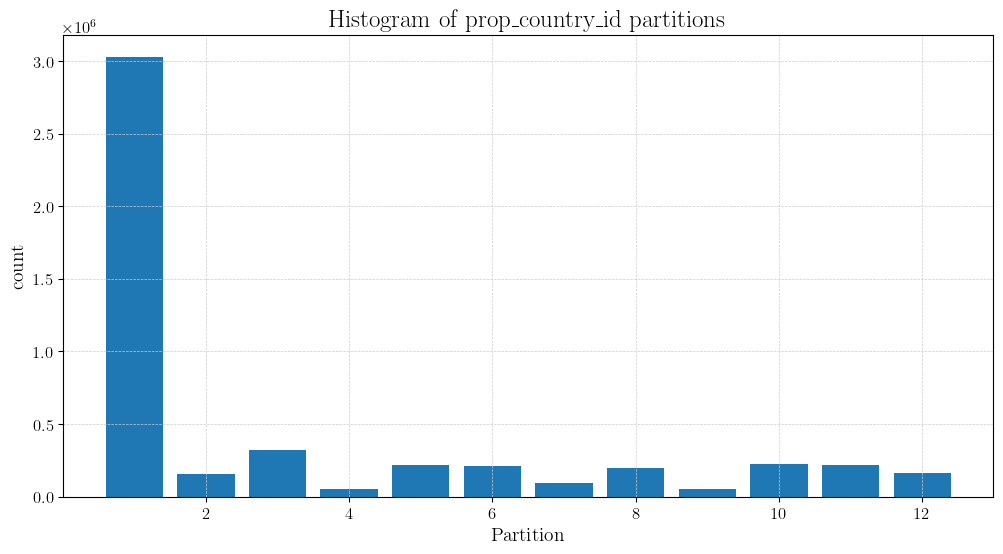

In [101]:
plt.figure(figsize=(12, 6))
plt.bar(range(1, 13), [sum(count.filter(count['prop_country_id'].is_in(part))['count']) for part in partitions_list])
plt.xlabel('Partition')
plt.ylabel('count')
plt.title('Histogram of prop_country_id partitions')

In [6]:
def split_data_set(data, partitions_list):
    data_partitions = []
    for part in partitions_list:
        data_partitions.append(data.loc[data['prop_country_id'].isin(part)])
    return data_partitions


In [7]:
data = data.sort(['srch_id', 'booking_bool', 'click_bool'], descending=[False, True, True])

In [88]:
# Convert polars DataFrames to pandas DataFrames
data_pd = data.to_pandas()
# replace all NULL values with np.nan
data_pd = data_pd.replace('NULL', np.nan)
ranking_pd = data_pd[['srch_id', 'prop_id']]

# Convert object columns to appropriate data types
object_columns = data_pd.select_dtypes(include=['object']).columns
data_pd[object_columns] = data_pd[object_columns].apply(pd.to_numeric, errors='coerce')

# Split the data into features (X) and target (y)
X = data_pd.drop(['srch_id'], axis=1)
y = ranking_pd['prop_id']


# Split the data into training and testing sets based on srch_id
srch_ids = data_pd['srch_id'].unique()
train_srch_ids, test_srch_ids = train_test_split(srch_ids, test_size=0.2, random_state=42)

# Create training and testing DataFrames
train_data = data_pd[data_pd['srch_id'].isin(train_srch_ids)]
test_data = data_pd[data_pd['srch_id'].isin(test_srch_ids)]


split_train = split_data_set(train_data, partitions_list)
split_test = split_data_set(test_data, partitions_list)
split_full = split_data_set(data_pd, partitions_list)

In [92]:
def train_model(data, params, num_boost, drop_cols):
    # Create XGBoost DMatrix objects for training and testing
    train_dmatrix = xg.DMatrix(
        data.drop(drop_cols, axis=1),
        label=data['prop_id'],
        group=data['srch_id'].value_counts().sort_index().values
    )
    
    return xg.train(params, train_dmatrix, num_boost_round=100)

def evaluate_model(model, cdata, drop_cols):
    data = cdata.copy()

    # Capture the true order of prop_id before sorting

    # Create XGBoost DMatrix object for testing
    test_dmatrix = xg.DMatrix(
        data.drop(drop_cols, axis=1),
        group=data['srch_id'].value_counts().sort_index().values
    )

    # Make predictions on the test set
    test_pred = model.predict(test_dmatrix)
    data['pred'] = test_pred

    # Order the prop_ids based on the predictions
    results = data.sort_values(['srch_id', 'pred'], ascending=[True, False])[['srch_id', 'prop_id']]
    

    grouped = results.groupby('srch_id')['prop_id'].apply(list)
    
    return grouped.to_frame()


def eval_models_partions(models, split_test, drop_cols, ncdg=True):
    df = pd.DataFrame()
    for model, part in zip(models, split_test):
        grouped = evaluate_model(model, part, drop_cols)
        true = part.groupby('srch_id')['prop_id'].apply(list)
        grouped['prop_id_true'] = true

        if ncdg:
            grouped['ndcg'] = grouped.apply(lambda x: ndcg_score([x['prop_id_true']], [x['prop_id']], k=5) if len(x['prop_id_true']) > 1 else None, axis=1)
            print("NDCG Score: ", grouped['ndcg'].mean())
        df = pd.concat([df, grouped])
    return df


def train_models(split_train, params, num_boost, drop_cols):
    models = []
    for part in tqdm(split_train):
        model = train_model(part, params, num_boost, drop_cols)
        models.append(model)
    return models

In [89]:
# Set XGBoost parameters
params = {
    'objective': 'rank:pairwise', # the objective, can also be rank:ndcg, but that is buggy
    'lambdarank_pair_method': 'topk', # instead of looking at the mean, we look at the highest k
    'lambdarank_num_pair_per_sample': 6, # set slightly higher than intended k
    'eval_metric': 'ndcg',
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

drop_cols = ['srch_id','prop_id', 'booking_bool', 'gross_bookings_usd', 'position', 'click_bool']

models = train_models(split_train, params, 120, drop_cols)


  0%|          | 0/12 [00:00<?, ?it/s]

In [93]:
drop_cols = ['srch_id','prop_id', 'booking_bool', 'gross_bookings_usd', 'position', 'click_bool']
grouped = eval_models_partions(models, split_test, drop_cols)

NDCG Score:  0.558087713749949
NDCG Score:  0.5617006506263169
NDCG Score:  0.5236271658525239
NDCG Score:  0.5218362423689373
NDCG Score:  0.5611185122119089
NDCG Score:  0.5377220856106713
NDCG Score:  0.5376482259944536
NDCG Score:  0.5559450370050281
NDCG Score:  0.5047762094098726
NDCG Score:  0.5532280867413524
NDCG Score:  0.5748710369767882
NDCG Score:  0.5486515863496851


In [95]:
# Full training
models_full = train_models(split_full, params, 120, drop_cols)

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
# save the model

for i, model in enumerate(models_full):
    model.save_model(f'models/model_{i}.json')
# load the model
models_full = [xg.Booster() for i in range(len(models_full))]
models_full = [models_full[i].load_model(f'models/model_{i}.json') for i in range(len(models_full))]

In [94]:
test_set = pl.read_csv('../data/preprocessed/engineered_test_set.csv')
test_set = test_set.to_pandas()
test_set = test_set.replace('NULL', np.nan)

object_columns = test_set.select_dtypes(include=['object']).columns
test_set[object_columns] = test_set[object_columns].apply(pd.to_numeric, errors='coerce')

split_eval = split_data_set(test_set, partitions_list)

assert sum([len(x) for x in split_eval]) == len(test_set)

In [ ]:
test_set.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_brand_bool,srch_destination_id,...,price_per_person,avg_price_per_day,ump,price_diff,starrating_diff,total_price,score2ma,promotion_count,promotion_any,pred
0,1,NaN,24,216,NaN,NaN,219,3180,1,19222,...,59.5,119.0,33.933013,NaN,NaN,119.0,NaN,6,1,-5.039828
1,1,NaN,24,216,NaN,NaN,219,5543,1,19222,...,59.0,118.0,20.379512,NaN,NaN,118.0,NaN,6,1,-5.001843
2,1,NaN,24,216,NaN,NaN,219,14142,1,19222,...,24.5,49.0,15.071523,NaN,NaN,49.0,NaN,6,1,-4.660777
3,1,NaN,24,216,NaN,NaN,219,22393,1,19222,...,71.5,143.0,9.933013,NaN,NaN,143.0,NaN,6,1,-4.574502
4,1,NaN,24,216,NaN,NaN,219,24194,1,19222,...,39.5,79.0,33.168253,NaN,NaN,79.0,NaN,6,1,-4.570467


In [96]:
drop_cols = ['srch_id','prop_id']
grouped = eval_models_partions(models_full, split_eval, ncdg=False, drop_cols=drop_cols)

In [100]:
submission = grouped.explode('prop_id')
submission['srch_id'] = submission.index
submission = submission[['srch_id', 'prop_id']]

assert len(submission) == len(test_set)

submission.head()

,srch_id,prop_id
srch_id,,
1,1,89466
1,1,37567
1,1,128871
1,1,134992
1,1,128085


In [98]:
submission.to_csv('submit/submission.csv', index=False)

# old stuff for single model

In [ ]:
test_set_dmatrix = xg.DMatrix(test_set.drop(['srch_id'], axis=1), group=test_set['srch_id'].value_counts().sort_index().values)
test_set['pred'] = model.predict(test_set_dmatrix)

# same as earlier, without need for calculating the ndcg, so less steps
submission = test_set.sort_values(['srch_id', 'pred'], ascending=[True, False])[['srch_id', 'prop_id']]
submission.to_csv('submit/submission.csv', index=False)

In [ ]:
test_set = pl.read_csv('../data/preprocessed/engineered_test_set.csv')
shuffled_test_set = test_set.sort(['srch_id', 'price_per_person'], descending=[False, True])[['srch_id', 'prop_id']]


In [ ]:
shuffled_test_set.write_csv('submit/submission.csv')

In [ ]:
# srch_ids = test_set['srch_id'].unique()

# # Create an empty DataFrame to store the predictions
# submission_df = pd.DataFrame(columns=['srch_id', 'prop_id'])

# #  Unique srch_ids in the test set
# srch_ids = test_set['srch_id'].unique()

# # Pre-allocate a list to collect results
# results = []

# # Iterate over each srch_id and make predictions
# for srch_id in tqdm(srch_ids):
#     # Get the data for the current srch_id
#     srch_data = test_set[test_set['srch_id'] == srch_id]

#     # Create DMatrix for the current srch_id
#     srch_dmatrix = xg.DMatrix(srch_data.drop(['srch_id'], axis=1))

#     # Make predictions for the current srch_id
#     srch_pred = model.predict(srch_dmatrix)

#     # Get the corresponding prop_ids for the current srch_id
#     srch_prop_ids = srch_data['prop_id'].values

#     # Sort the prop_ids based on the predicted scores
#     sorted_indices = np.argsort(srch_pred)[::-1]
#     sorted_prop_ids = srch_prop_ids[sorted_indices]

#     # Collect the results for the current srch_id
#     results.append(pd.DataFrame({'srch_id': srch_id, 'prop_id': sorted_prop_ids}))

# # Concatenate all results into a single DataFrame
# submission_df = pd.concat(results, ignore_index=True)


# # Check final submission DataFrame size
# print(f"Expected number of entries: {len(test_set)}")
# print(f"Actual number of entries: {len(submission_df)}")

# # Save the submission DataFrame to a CSV file
# submission_df.to_csv('submit/submission.csv', index=False)